# 03 Haabersti hõberemmelgas konflikt

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import csv
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
from wordcloud import WordCloud
from estnltk import Text
import re

In [2]:
konflikt = 'Haabersti hõberemmelgas'
data = pd.read_excel('remmelgas/KÕIK TEKSTID_Haabersti_hoberemmelgas.xlsx', engine='openpyxl')

In [4]:
data.shape

(306, 8)

## 1. Andmete töötlemine

In [5]:
date = data['date'].to_list()

In [7]:
# Artikli kuupäeva teisendamine

kuupäevad = []
aastad = []
kuud = []
päevad = []
aasta_kuud =[]
for d in date:
    match = re.search(r'\d{4}\-\d{2}\-\d{2}', d)
    if match:
        kuupäev = match[0][0:10]
        aasta = match[0][0:4]
        kuu = match[0][5:7]
        päev = match[0][8:10]
        aasta_kuu = match[0][0:7]
    kuupäevad.append(kuupäev) 
    aastad.append(aasta)
    kuud.append(kuu)
    päevad.append(päev)
    aasta_kuud.append(aasta_kuu)

In [8]:
# Tunnuste lisamine andmestikku

data['kuupäev']=kuupäevad
data['aasta']=aastad
data['kuu']=kuud
data['päev']=päevad
data['aasta_kuu']=aasta_kuud

In [9]:
# Mittevajalike tunnuste eemaldamine

del data['date']

In [10]:
data.shape

(306, 12)

## 2. Väljaanded

In [11]:
jaotus1 = data['subject'].value_counts(ascending = False)
tabel1 = pd.DataFrame({'Väljaande nimi':jaotus1.index, 'Artikleid':jaotus1.values})
tabel1['Osakaal, %'] = round((tabel1['Artikleid'] / 
                      tabel1['Artikleid'].sum() )* 100, 1)
tabel1_1 = tabel1.style.set_caption(konflikt + ": vaadeldud artikleid väljaannete kaupa")
tabel1.to_excel("tulemused_" + konflikt +"/" + konflikt + " tabel1_Väljaanded.xlsx") 

In [12]:
tabel1_1

,Väljaande nimi,Artikleid,"Osakaal, %"
0,Postimees,91,29.700000
1,Õhtuleht,48,15.700000
2,Delfi,42,13.700000
3,ERR,26,8.500000
4,Eesti Päevaleht,18,5.900000
5,Pealinn,15,4.900000
6,Maaleht,10,3.300000
7,Uued Uudised,9,2.900000
8,Eesti Ekspress,5,1.600000
9,"ERR, Vikerraadio päevakommentaar",5,1.600000


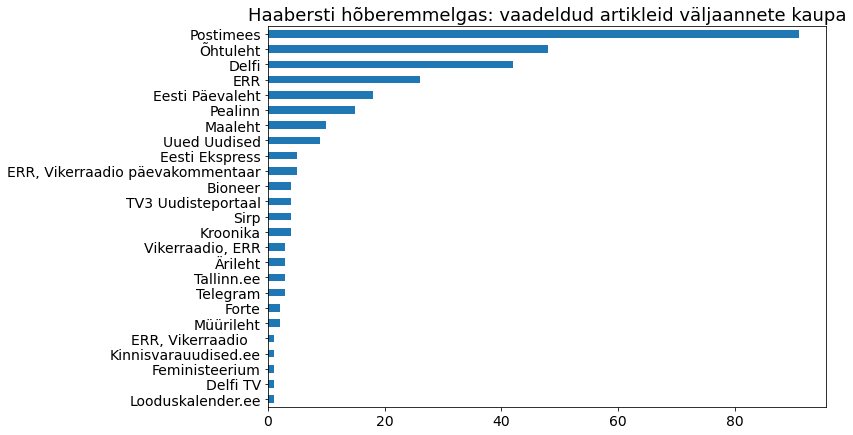

In [13]:
fig, ax = plt.subplots(figsize=(10,7))
plt.title(konflikt + ": vaadeldud artikleid väljaannete kaupa", size=18)
data['subject'].value_counts(ascending = True).plot(ax=ax, kind='barh', fontsize=14)
plt.savefig("tulemused_" + konflikt +"/" + konflikt + " joonis1_Väljaanded.png")
plt.show()

## 3. Sõnapilvede loomine

In [14]:
#https://et.wikipedia.org/wiki/Sides%C3%B5na
#https://www.taskutark.ee/m/asesonad/
#sidesõnad
stopsõnad = ['ja', 'ning', 'ega', 'ehk', 'või', 'aga', 'kuid', 'ent', 'vaid', 'et', 'kui', 'kuna', 'sest', 'kuni', 'kuigi', 
             'ehkki', 'nagu', 'saati', 'elik', 'justkui', 'otsekui', 'seni']
#sidesõnad ja asesõnad
stopsõnad_uus = ['ja', 'ning', 'ega', 'ehk', 'või', 'aga', 'kuid', 'ent', 'vaid', 'et', 'kui', 'kuna', 'sest', 'kuni', 'kuigi', 
             'ehkki', 'nagu', 'saati', 'elik', 'justkui', 'otsekui', 'seni', 'siis', 'ka', 'nii', 'kas',
             'mina', 'ma', 'meie', 'me', 'sina', 'sa', 'teie', 'te', 'tema', 'ta', 'nemad', 'nad',
             'enese', 'enda', 'iseenese', 'iseenda', 'oma', 'üksteise', 'teineteise',
             'see', 'too', 'sama', 'seesama', 'toosama', 'teine', 'muu',
             'niisugune', 'samasugune', 'niisamasugune', 'selline', 'seesugune', 'säärane','säherdune', 
             'taoline', 'selletaoline', 'kes', 'mis', 'kumb', 'missugune', 'milline', 'misuke', 'mitu', 'mitmes', 'mitmendik',
             'ise', 'oma', 'iga', 'igaüks', 'igamees', 'kõik', 'mõlemad', 'kumbki', 'emb-kumb', 'kogu', 'terve',
             'keegi', 'miski', 'mingi', 'mingisugune', 'miskisugune', 'ükski', 'mitu', 'mitmes', 'mitu-setu', 'mitmes-setmes',
             'mõni', 'mõningane', 'paljud', 'üks', 'teine', 'oma', 'enese', 'enda', 'omaenese', 'omaenda', 'iseoma', 
             'iseenese', 'iseenda', 'emb', 'mõlema', 'palju']

## 3.1 Nimi- ja omadussõnad

### 3.1.1 Nimi- ja omadussõnad artiklite pealkirjades

EstNLTK vahenditega vaadeldakse uudistes esinevate sõnade lemmasid ja sõnade liike. Edaspidiseks vaatluseks eraldatakse nimisõnad (sõnaliik S) ja  omadussõnad (sõnaliigid A - algvõrre, C - keskvõrre, U - ülivõrre).

In [15]:
# Nimisõnade ja omadussõnade kasutamine

nimi_omadus_sonad = []
for i in tqdm(range (0, len(data))):
    rida = data.iloc[i]
    tekst = Text(rida[1]).tag_layer().morph_analysis['lemma','partofspeech']
    for sona in tekst:
        if sona[0][1] == 'S' or sona[0][1] == 'A' or sona[0][1] == 'C' or sona[0][1] == 'U':
            nimi_omadus_sonad.append(sona[0][0])

nimi_omadus_words = ' '.join(map(str, nimi_omadus_sonad))

100%|███████████████████████████████████████████████████████████████████████████████| 306/306 [00:01<00:00, 167.73it/s]


Haabersti hõberemmelgas: pealkirjades nimisõnu ja omadussõnu sõnapilves:  1199


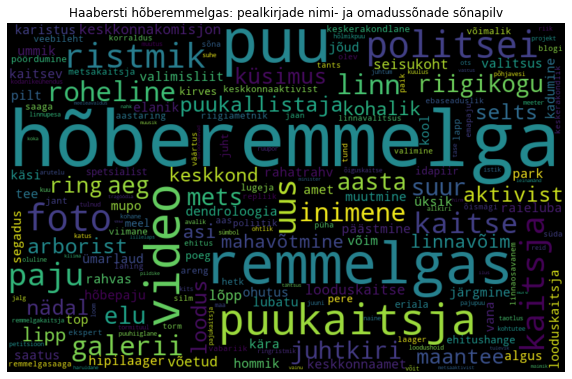

In [16]:
wordcloud_nimi_omadus = WordCloud(stopwords = stopsõnad_uus, width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(nimi_omadus_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud_nimi_omadus, interpolation='bilinear')
plt.title(konflikt + ": pealkirjade nimi- ja omadussõnade sõnapilv")
plt.savefig("tulemused_" + konflikt +"/" + konflikt + ' joonis2_Pealkirjad_nimi_omadus_sonapilv.png')
plt.axis("off")
print(konflikt + ": pealkirjades nimisõnu ja omadussõnu sõnapilves: ", len(nimi_omadus_sonad))

### 3.1.2 Nimi- ja omadussõnade esinemissagedus artiklite pealkirjades

In [17]:
jaotus2 =pd.DataFrame(nimi_omadus_sonad, columns=['sõna'])
tabel2 = jaotus2.groupby(['sõna']).size().reset_index(name='esinemissagedus').sort_values(by='esinemissagedus', ascending=False)[:10]
tabel2['osakaal %']= (tabel2['esinemissagedus']/len(nimi_omadus_sonad)*100)
tabel2_1 = tabel2.style.set_caption(konflikt + ": pealkirjade nimi- ja omadussõnade TOP 10")
tabel2.to_excel("tulemused_" + konflikt +"/" + konflikt + " tabel2_Pealkirjad_nimi_omadus_TOP_10.xlsx") 

In [18]:
tabel2_1

,sõna,esinemissagedus,osakaal %
109,hõberemmelgas,72,6.005004
387,puu,43,3.586322
432,remmelgas,38,3.169308
572,video,27,2.251877
391,puukaitsja,21,1.751460
85,foto,15,1.251043
371,politsei,15,1.251043
447,ristmik,13,1.084237
148,kaitsja,12,1.000834
349,paju,11,0.917431


### 3.1.3 Nimi- ja omadussõnade kasutamine artiklite tekstides

In [19]:
# Nimisõnade ja omadussõnade kasutamine

nimi_omadus_sonad1 = []
for i in tqdm(range (0, len(data))):
    rida = data.iloc[i]
    tekst = Text(rida[2]).tag_layer().morph_analysis['lemma','partofspeech']
    for sona in tekst:
        if sona[0][1] == 'S' or sona[0][1] == 'A' or sona[0][1] == 'C' or sona[0][1] == 'U':
            nimi_omadus_sonad1.append(sona[0][0])

nimi_omadus_words1 = ' '.join(map(str, nimi_omadus_sonad1))

100%|████████████████████████████████████████████████████████████████████████████████| 306/306 [01:10<00:00,  4.31it/s]


Haabersti hõberemmelgas: tekstides nimisõnu ja omadussõnu sõnapilves  48880


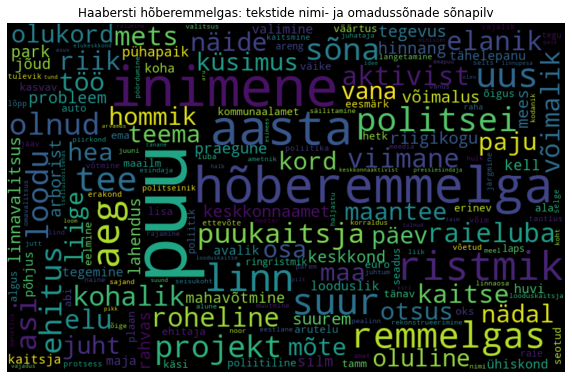

In [20]:
wordcloud_nimi_omadus1 = WordCloud(stopwords = stopsõnad_uus, width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(nimi_omadus_words1)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud_nimi_omadus1, interpolation='bilinear')
plt.title(konflikt + ": tekstide nimi- ja omadussõnade sõnapilv")
plt.savefig("tulemused_" + konflikt +"/" + konflikt + ' joonis3_Tekstid_nimi_omadus_sonapilv.png')
plt.axis("off")
print(konflikt + ": tekstides nimisõnu ja omadussõnu sõnapilves ", len(nimi_omadus_sonad1))

### 3.1.4 Nimi- ja omadussõnade esinemissagedus artiklite tekstides

In [21]:
jaotus3 =pd.DataFrame(nimi_omadus_sonad1, columns=['sõna'])
tabel3 = jaotus3.groupby(['sõna']).size().reset_index(name='esinemissagedus').sort_values(by='esinemissagedus', ascending=False)[:10]
tabel3['osakaal %']= (tabel3['esinemissagedus']/len(nimi_omadus_sonad1)*100)
tabel3_1 = tabel3.style.set_caption(konflikt + ": tekstide nimi- ja omadussõnade TOP 10")
tabel3.to_excel("tulemused_" + konflikt +"/" + konflikt + " tabel3_Tekstid_nimi_omadus_TOP_10.xlsx") 

In [22]:
tabel3_1

,sõna,esinemissagedus,osakaal %
5935,puu,1586,3.244681
1790,inimene,699,1.430033
1645,hõberemmelgas,575,1.176350
64,aasta,546,1.117021
6562,ristmik,355,0.726268
112,aeg,324,0.662848
3769,linn,314,0.642390
7167,suur,301,0.615794
6460,remmelgas,273,0.558511
8382,uus,254,0.519640


## 3.2 Verbid

### 3.2.1 Verbid artiklite pealkirjades

100%|███████████████████████████████████████████████████████████████████████████████| 306/306 [00:01<00:00, 170.83it/s]


Haabersti hõberemmelgas: verbe sõnapilves  458


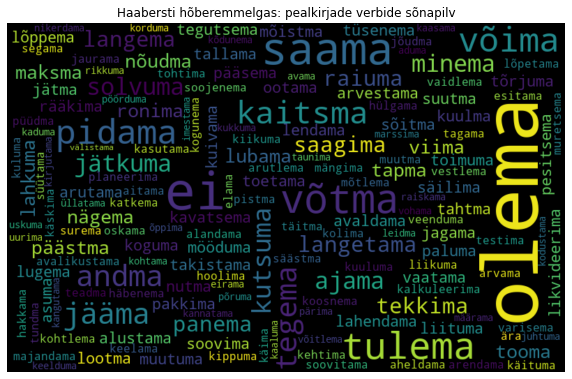

In [23]:
verb_sonad = []
for i in tqdm(range (0, len(data))):
    rida = data.iloc[i]
    tekst = Text(rida[1]).tag_layer().morph_analysis['lemma','partofspeech']
    for sona in tekst:
        if sona[0][1] == 'V':
            verb_sonad.append(sona[0][0])

verb_words = ' '.join(map(str, verb_sonad))

wordcloud_verb = WordCloud(stopwords = stopsõnad_uus, width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(verb_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud_verb, interpolation='bilinear')
plt.title(konflikt + ": pealkirjade verbide sõnapilv")
plt.savefig("tulemused_" + konflikt +"/" + konflikt + ' joonis4_Pealkirjad_verbid_sonapilv.png')
plt.axis("off")
print(konflikt + ": verbe sõnapilves ", len(verb_sonad))

### 3.2.2 Verbide esinemissagedus artiklite pealkirjades

In [24]:
jaotus4 =pd.DataFrame(verb_sonad, columns=['sõna'])
tabel4 = jaotus4.groupby(['sõna']).size().reset_index(name='esinemissagedus').sort_values(by='esinemissagedus', ascending=False)[:10]
tabel4['osakaal %']= (tabel4['esinemissagedus']/len(verb_sonad)*100)
tabel4_1 = tabel4.style.set_caption(konflikt + ": pealkirjade verbide TOP 10")
tabel4.to_excel("tulemused_" + konflikt +"/" + konflikt + " tabel4_Pealkirjad_verbid_TOP_10.xlsx")

In [25]:
tabel4_1

,sõna,esinemissagedus,osakaal %
96,olema,75,16.375546
16,ei,26,5.676856
118,saama,19,4.148472
162,võtma,15,3.275109
145,tulema,13,2.838428
103,pidama,11,2.401747
160,võima,11,2.401747
35,kaitsma,9,1.965066
6,andma,8,1.746725
137,tegema,8,1.746725


### 3.2.3 Verbid artiklite tekstides

100%|████████████████████████████████████████████████████████████████████████████████| 306/306 [01:10<00:00,  4.34it/s]


Haabersti hõberemmelgas: verbe sõnapilves:  26090


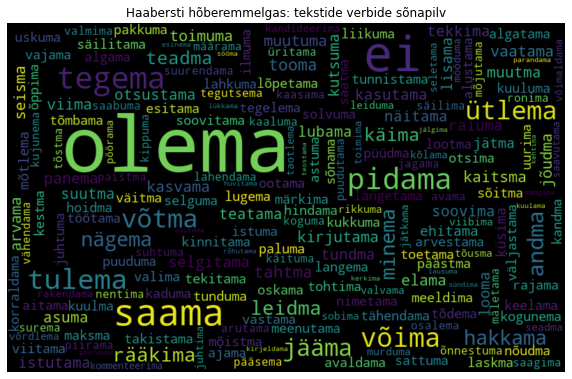

In [26]:
verb_sonad1 = []
for i in tqdm(range (0, len(data))):
    rida = data.iloc[i]
    tekst = Text(rida[2]).tag_layer().morph_analysis['lemma','partofspeech']
    for sona in tekst:
        if sona[0][1] == 'V':
            verb_sonad1.append(sona[0][0])

verb_words1 = ' '.join(map(str, verb_sonad1))

wordcloud_verb1 = WordCloud(stopwords = stopsõnad_uus, width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(verb_words1)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud_verb1, interpolation='bilinear')
plt.title(konflikt + ": tekstide verbide sõnapilv")
plt.savefig("tulemused_" + konflikt +"/" + konflikt + ' joonis5_Tekstid_verbid_sonapilv.png')
plt.axis("off")
print(konflikt + ": verbe sõnapilves: ", len(verb_sonad1))

### 3.2.4 Verbide esinemissagedus artiklite tekstides

In [27]:
jaotus5 =pd.DataFrame(verb_sonad1, columns=['sõna'])
tabel5 = jaotus5.groupby(['sõna']).size().reset_index(name='esinemissagedus').sort_values(by='esinemissagedus', ascending=False)[:10]
tabel5['osakaal %']= (tabel5['esinemissagedus']/len(verb_sonad1)*100)
tabel5_1 = tabel5.style.set_caption(konflikt + ": tekstide verbide TOP 10")
tabel5.to_excel("tulemused_" + konflikt +"/" + konflikt +  " tabel5_Tekstid_verbid_TOP_10.xlsx")

In [28]:
tabel5_1

,sõna,esinemissagedus,osakaal %
677,olema,5969,22.878498
92,ei,1679,6.435416
905,saama,844,3.234956
1077,tegema,557,2.134918
744,pidama,510,1.954772
1133,tulema,470,1.801456
1304,võima,424,1.625144
1314,võtma,409,1.567650
1347,ütlema,402,1.540820
258,jääma,339,1.299348


# 4. Meediakajastus ajalisel skaalal

In [29]:
jaotus6 = data['aasta'].value_counts().sort_index()
tabel6 = pd.DataFrame({'Aasta':jaotus6.index, 'Artikleid':jaotus6.values})
tabel6['Osakaal, %'] = round((tabel6['Artikleid'] / 
                      tabel6['Artikleid'].sum() )* 100, 1)
tabel6_1 = tabel6.style.set_caption(konflikt + ": vaadeldud artikleid aastate lõikes")
tabel6.to_excel("tulemused_" + konflikt +"/" + konflikt + " tabel6_Aastate_lõikes.xlsx") 

In [30]:
tabel6_1

,Aasta,Artikleid,"Osakaal, %"
0,2001,1,0.300000
1,2002,1,0.300000
2,2006,1,0.300000
3,2008,2,0.700000
4,2010,1,0.300000
5,2011,2,0.700000
6,2015,3,1.000000
7,2017,240,78.400000
8,2018,35,11.400000
9,2019,7,2.300000


C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


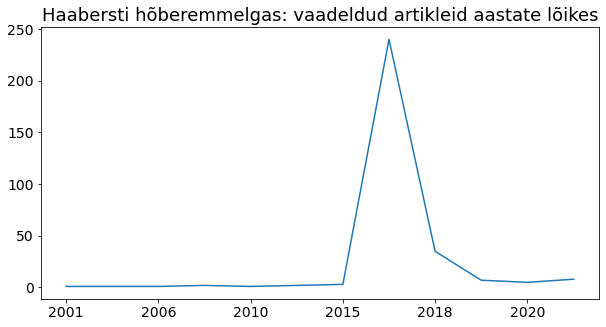

In [31]:
fig, ax = plt.subplots(figsize=(10,5))
plt.title(konflikt + ": vaadeldud artikleid aastate lõikes", size=18)
data['aasta'].value_counts().sort_index().plot(ax=ax, kind='line', fontsize=14)
plt.savefig("tulemused_" + konflikt +"/" + konflikt + " joonis6_Aastate_lõikes.png")
plt.show()

In [32]:
jaotus7 = data['aasta_kuu'].value_counts().sort_index()
tabel7 = pd.DataFrame({'Aasta':jaotus7.index, 'Artikleid':jaotus7.values})
tabel7['Osakaal, %'] = round((tabel7['Artikleid'] / 
                      tabel7['Artikleid'].sum() )* 100, 1)
tabel7_1 = tabel7.style.set_caption(konflikt + ": vaadeldud artikleid aastate ja kuude lõikes")
tabel7.to_excel("tulemused_" + konflikt +"/" + konflikt + " tabel7_Aastate_kuude_lõikes.xlsx") 

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


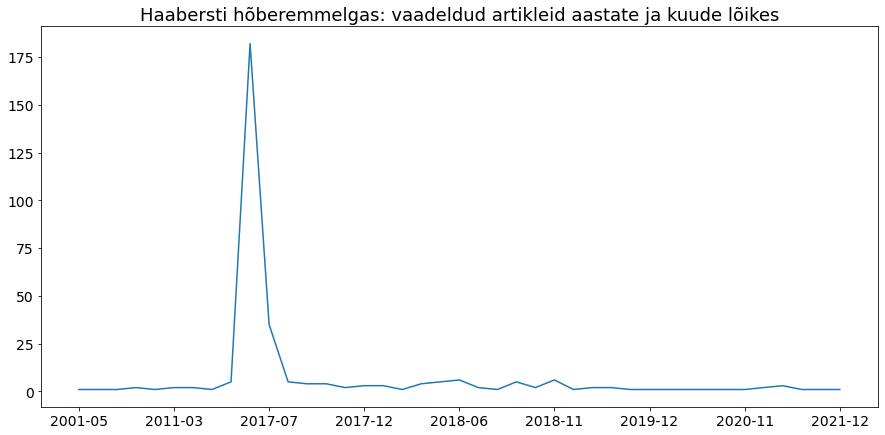

In [33]:
fig, ax = plt.subplots(figsize=(15,7))
plt.title(konflikt + ": vaadeldud artikleid aastate ja kuude lõikes", size=18)
data['aasta_kuu'].value_counts().sort_index().plot(ax=ax, kind='line', fontsize=14)
plt.savefig("tulemused_" + konflikt +"/" + konflikt + " joonis7_Aastate_kuude_lõikes.png")
plt.show()

# 5. Nimed

In [34]:
# Loome uue nimeüksuste tuvastaja 
from estnltk.taggers import NerTagger
ner_tagger = NerTagger()
# Milliseid kihte ner_tagger vajab?
ner_tagger.input_layers

('morph_analysis',)

In [35]:
tekst = data['text'].to_list()

In [36]:
# Otsitakse tekstist nimesid

nimed_texts = []
nimed_labels = []
from estnltk import Text

for k in tekst:
    t= Text(k).tag_layer('morph_analysis')
    # lisame nimeüksuste märgenduse
    ner_tagger.tag(t)
    # leia nimeüksuste liigid
    entity_labels = t.ner[['nertag']]
    # leia nimeüksuste tekstijupid
    entity_texts = [ne.enclosing_text for ne in t.ner]
    # leia nimeüksuste asukohad
    entity_spans = [(ne.start, ne.end) for ne in t.ner]

    # väljastab tuvastatud nimeüksused koos nende asukohtade, tekstijuppide ja liikidega:
    for ne_phrase, ne_label, ne_span in zip(entity_texts, entity_labels, entity_spans):
        print( ne_span, ne_phrase, ne_label )
    nimed_texts.append(entity_texts)
    nimed_labels.append(entity_labels)

(0, 14) Eesti Ekspress ['ORG']
(141, 150) Tallinnas ['LOC']
(151, 171) Toompeal ja Vabaduse ['ORG']
(263, 272) Riigikogu ['ORG']
(638, 650) SILVIA ILVES ['PER']
(800, 805) Urmas ['PER']
(878, 891) Lääne-Eestist ['LOC']
(914, 919) Eesti ['LOC']
(932, 937) Urmas ['PER']
(971, 986) Indrek Tarandit ['PER']
(1029, 1041) Silvia Ilves ['PER']
(1857, 1865) Toompeal ['ORG']
(2068, 2075) Katrina ['PER']
(2187, 2197) Tallinnast ['LOC']
(2765, 2774) Mari-Anna ['PER']
(2803, 2813) Mari-Annal ['LOC']
(2861, 2868) Evelini ['PER']
(2872, 2877) Argot ['PER']
(2897, 2905) Toompeal ['ORG']
(3941, 3954) Argoja Evelin ['ORG']
(4028, 4037) Ekspressi ['ORG']
(4233, 4245) Erik Moorale ['PER']
(4328, 4337) Evelinist ['PER']
(4341, 4347) Argost ['PER']
(4395, 4401) Evemaa ['PER']
(4403, 4409) Evelin ['PER']
(4434, 4438) Argo ['PER']
(4450, 4457) Evelini ['PER']
(4461, 4465) Argo ['PER']
(4480, 4491) Veiko Huuse ['PER']
(4509, 4513) Vaba ['PER']
(4514, 4519) Eesti ['LOC']
(4541, 4546) Argot ['PER']
(4550, 4557) 

(20, 33) Janek Mäggiga ['PER']
(75, 87) Indrek Vainu ['PER']
(95, 104) Maalehele ['ORG']
(156, 161) Tartu ['LOC']
(187, 199) Indrek Vainu ['PER']
(264, 272) Eestisse ['LOC']
(372, 376) SVEN ['PER']
(377, 382) ARBET ['PER']
(480, 485) Tartu ['LOC']
(1171, 1181) Mati Polli ['PER']
(1182, 1185) RMK ['ORG']
(1262, 1272) Aadu Polli ['PER']
(1278, 1293) Margus Kohavaga ['PER']
(1303, 1313) Mati Polli ['PER']
(1587, 1592) Sampo ['LOC']
(1644, 1661) Est-For Invest OÜ ['ORG']
(1915, 1930) Siim Kiisleriga ['PER']
(2039, 2046) Kiisler ['PER']
(2124, 2134) Kiislerile ['PER']
(2239, 2251) Vabaerakonna ['ORG']
(2312, 2321) Kiisleril ['PER']
(2424, 2435) Janek Mäggi ['PER']
(3682, 3696) Graanul Invest ['ORG']
(3700, 3705) Eesti ['LOC']
(3869, 3880) Janek Mäggi ['PER']
(3916, 3921) Mäggi ['PER']
(4217, 4222) Mäggi ['PER']
(4465, 4470) Mäggi ['PER']
(4494, 4507) Indrek Vainut ['PER']
(4941, 4953) Tartu linnal ['LOC']
(4983, 4988) Tartu ['LOC']
(5125, 5137) Tartu linnal ['LOC']
(5200, 5212) Tartu linnal

(11, 20) Haabersti ['LOC']
(99, 109) Haaberstis ['LOC']
(676, 684) Paldiski ['LOC']
(1155, 1163) Paldiski ['LOC']
(2236, 2241) Nõmme ['LOC']
(2399, 2405) Nõmmel ['LOC']
(2448, 2458) Haaberstis ['LOC']
(2696, 2705) Haabersti ['LOC']
(3831, 3835) Paju ['LOC']
(4323, 4327) Paju ['LOC']
(4351, 4360) Tallinnas ['LOC']
(4883, 4889) Eestis ['LOC']
(6, 12) Krimmi ['LOC']
(40, 48) Eestisse ['LOC']
(149, 160) Rikaste TOP ['ORG']
(178, 184) Markus ['PER']
(188, 201) Martin Villig ['PER']
(216, 221) Eesti ['LOC']
(292, 298) Taxify ['PER']
(357, 363) Krimmi ['LOC']
(391, 399) Eestisse ['LOC']
(400, 405) Tõnis ['PER']
(406, 411) Palts ['PER']
(434, 446) Tõnis Paltsu ['PER']
(468, 481) Paltsu Krimmi ['PER']
(536, 544) Koit Uus ['PER']
(548, 560) Toomas Annus ['PER']
(581, 589) Paltsule ['PER']
(631, 643) Sevastoopoli ['LOC']
(759, 766) Venemaa ['LOC']
(767, 783) Krimmi poolsaare ['LOC']
(784, 793) Ukrainalt ['LOC']
(805, 810) Palts ['PER']
(861, 885) Vene kaitseministeeriumi ['ORG']
(905, 911) Paltsu

(474, 490) Kersti Kaljulaid ['PER']
(709, 713) EMSL ['ORG']
(2670, 2680) Facebookis ['LOC']
(2698, 2703) Nõmme ['LOC']
(2968, 2979) Rail Baltic ['PER']
(2994, 3003) Haabersti ['LOC']
(3033, 3040) Rakvere ['LOC']
(3236, 3248) Madle Lippus ['PER']
(3670, 3682) Artur Talvik ['PER']
(3698, 3703) Eesti ['LOC']
(3857, 3869) Vabaerakonna ['ORG']
(3969, 3977) Tallinna ['LOC']
(4105, 4114) Erik Vest ['PER']
(4147, 4157) Pelgulinna ['LOC']
(4193, 4198) Nõmme ['LOC']
(4214, 4223) Ülle Mitt ['PER']
(0, 9) Haabersti ['LOC']
(270, 282) Indrek Vainu ['PER']
(318, 328) Geenius.ee ['PER']
(435, 444) Tallinnas ['LOC']
(694, 703) Haabersti ['LOC']
(912, 922) Geeniusele ['PER']
(956, 961) Vainu ['PER']
(993, 1002) Haabersti ['LOC']
(21, 29) Tallinna ['LOC']
(48, 60) Rainer Vakra ['PER']
(80, 89) Haabersti ['LOC']
(124, 133) Tallinnas ['LOC']
(497, 502) Vakra ['PER']
(781, 790) Tallinnas ['LOC']
(970, 975) Vakra ['PER']
(0, 5) Delfi ['ORG']
(31, 40) Haabersti ['LOC']
(265, 274) Haabersti ['LOC']
(323, 334)

(176, 185) Haabersti ['LOC']
(638, 653) Kakumäe Selveri ['ORG']
(657, 666) Haabersti ['LOC']
(731, 737) Õismäe ['LOC']
(769, 776) Arigato ['ORG']
(819, 822) BMW ['ORG']
(1067, 1075) Bauhausi ['PER']
(1120, 1128) Ameerika ['LOC']
(1390, 1399) Haabersti ['LOC']
(1656, 1665) Haabersti ['LOC']
(1764, 1772) Paldiski ['LOC']
(2822, 2831) Tallinnas ['LOC']
(3176, 3186) Haaberstis ['LOC']
(71, 82) Rauno Vinni ['PER']
(93, 102) Haabersti ['LOC']
(1032, 1037) Eesti ['LOC']
(1573, 1579) Eestis ['LOC']
(2266, 2281) Tallinna linnas ['LOC']
(2946, 2955) Haabersti ['LOC']
(3420, 3429) Haabersti ['LOC']
(21, 33) Raamatusõber ['PER']
(47, 51) Vaba ['PER']
(71, 80) Kookosõli ['ORG']
(116, 125) Slovakkia ['LOC']
(144, 152) Eestisse ['LOC']
(209, 220) Ingrid Peek ['PER']
(278, 284) Kosmos ['PER']
(351, 363) RAAMATUSÕBER ['PER']
(364, 373) RÕÕMUSTAB ['PER']
(404, 429) Eesti Rahvusraamatukogust ['ORG']
(564, 568) VABA ['PER']
(816, 824) Ameerika ['LOC']
(1030, 1049) Hõberemmelgallistus ['PER']
(1091, 1117) 

(0, 9) Riigikogu ['ORG']
(16, 29) Peeter Ernits ['PER']
(51, 60) Haabersti ['LOC']
(218, 224) Ernits ['PER']
(435, 441) Ernits ['PER']
(525, 533) Tallinna ['LOC']
(574, 583) Tallinnas ['LOC']
(667, 674) Ernitsa ['PER']
(812, 818) Ernits ['PER']
(983, 990) Ernitsa ['PER']
(1008, 1015) Tallinn ['LOC']
(1034, 1042) Rohelise ['ORG']
(1058, 1069) Jüri Ratase ['PER']
(1133, 1139) Ernits ['PER']
(1346, 1352) Ernits ['PER']
(1354, 1363) Haabersti ['LOC']
(1473, 1495) Tallinna keskkonnaamet ['ORG']
(1732, 1742) Facebookis ['LOC']
(1860, 1869) Haabersti ['LOC']
(2023, 2041) Eerik-Niiles Kross ['PER']
(2043, 2055) Artur Talvik ['PER']
(2057, 2066) Mart Nutt ['PER']
(2070, 2082) Rainer Vakra ['PER']
(2160, 2169) Haabersti ['LOC']
(53, 71) Eerik-Niiles Kross ['PER']
(73, 85) Artur Talvik ['PER']
(87, 96) Mart Nutt ['PER']
(100, 112) Rainer Vakra ['PER']
(196, 205) Haabersti ['LOC']
(436, 459) Tallinna linnavalitsuse ['ORG']
(463, 477) Tallinna linna ['LOC']
(509, 514) Eesti ['LOC']
(642, 651) Haabe

(84, 101) Eesti Metsa Abiks ['ORG']
(103, 106) EMA ['PER']
(134, 145) Tallinnasse ['LOC']
(146, 155) Haabersti ['LOC']
(329, 333) ERRi ['ORG']
(680, 697) Põhja prefektuuri ['ORG']
(713, 723) Seiko Kuik ['PER']
(724, 731) BNS-ile ['ORG']
(904, 923) Kodanikeühendus EMA ['PER']
(1254, 1260) Eestis ['LOC']
(1317, 1327) Linda-Mari ['PER']
(1328, 1332) Väli ['PER']
(1337, 1346) Facebooki ['PER']
(1354, 1363) Haabersti ['LOC']
(1428, 1434) Eestis ['LOC']
(63, 72) Tallinnas ['LOC']
(73, 83) Haaberstis ['LOC']
(216, 228) Keskerakonda ['ORG']
(245, 258) Peeter Ernits ['PER']
(280, 287) ERR-ile ['ORG']
(522, 531) Haabersti ['LOC']
(707, 730) Tallinna keskkonnaameti ['ORG']
(788, 811) Tallinna linnavalitsuse ['ORG']
(902, 917) Tallinna linnas ['LOC']
(1058, 1067) Tallinnas ['LOC']
(1131, 1139) Paldiski ['LOC']
(1233, 1242) Haabersti ['LOC']
(1349, 1358) Haabersti ['LOC']
(1466, 1483) Eesti Metsa Abiks ['ORG']
(1485, 1488) EMA ['PER']
(1531, 1540) Tallinnas ['LOC']
(1541, 1551) Haaberstis ['LOC']
(

(0, 9) Riigikogu ['ORG']
(32, 45) Peeter Ernits ['PER']
(57, 65) Tallinna ['LOC']
(110, 120) Taavi Aasa ['ORG']
(128, 138) Haaberstis ['LOC']
(237, 249) Taavi Aasaga ['PER']
(294, 300) Ernits ['PER']
(385, 398) Aas Ernitsale ['PER']
(407, 413) Ernits ['PER']
(560, 565) Taavi ['PER']
(670, 676) Ernits ['PER']
(701, 724) Tallinna keskkonnaameti ['ORG']
(730, 739) Relo Ligi ['PER']
(749, 755) Ernits ['PER']
(798, 807) Haabersti ['LOC']
(875, 885) Masinavärk ['PER']
(1266, 1288) Tallinna Keskkonnaamet ['ORG']
(1733, 1746) Keskkonnaamet ['ORG']
(1792, 1801) Haabersti ['LOC']
(21, 30) Tallinnas ['LOC']
(54, 68) Urmas Sõõrumaa ['PER']
(95, 104) Haabersti ['LOC']
(227, 247) Eesti Olümpiakomitee ['ORG']
(271, 279) Sõõrumaa ['PER']
(287, 300) Vikerraadiole ['ORG']
(492, 500) Sõõrumaa ['PER']
(768, 776) Sõõrumaa ['PER']
(969, 974) Soome ['LOC']
(1014, 1022) Sõõrumaa ['PER']
(1025, 1034) Kesklinna ['LOC']
(179, 192) MTÜ Haabersti ['ORG']
(277, 291) Indrek Kiisler ['PER']
(0, 9) Tallinnas ['LOC']
(

(0, 6) Eestis ['LOC']
(318, 321) MTÜ ['ORG']
(415, 421) MTÜsid ['ORG']
(561, 575) Kaitsepolitsei ['ORG']
(591, 605) Harrys Puusepp ['PER']
(802, 808) Kremli ['ORG']
(852, 859) Venemaa ['LOC']
(1419, 1423) NATO ['ORG']
(1487, 1500) Allan Hantsom ['PER']
(1511, 1524) Alexey Esakov ['PER']
(1528, 1541) Elina Esakova ['PER']
(1543, 1557) Sergei Tšaulin ['PER']
(1563, 1581) Alexander Kornilov ['PER']
(1589, 1597) Kornilov ['PER']
(1609, 1617) Altmedia ['PER']
(1622, 1635) Baltnewsmedia ['ORG']
(1639, 1660) Rahva Õiglustunde MTÜ ['ORG']
(1689, 1697) Altmedia ['LOC']
(1824, 1833) Altmedias ['PER']
(1950, 1968) maksuamet Altmedia ['ORG']
(2024, 2029) MTÜst ['ORG']
(2122, 2130) Kornilov ['PER']
(2294, 2300) Eestis ['LOC']
(2302, 2307) Lätis ['LOC']
(2312, 2318) Leedus ['LOC']
(2377, 2394) MTÜ Baltnewsmedia ['ORG']
(2408, 2416) Kornilov ['PER']
(2626, 2640) Kaitsepolitsei ['ORG']
(2675, 2684) Baltnewsi ['LOC']
(2709, 2725) Rossija Segodnja ['PER']
(2847, 2863) Rossija Segodnja ['PER']
(2949, 297

(84, 101) Eesti Metsa Abiks ['ORG']
(145, 153) Eestimaa ['LOC']
(170, 179) Tallinnas ['LOC']
(180, 189) Haabersti ['LOC']
(350, 358) Õhtulehe ['ORG']
(389, 397) Telegram ['PER']
(745, 751) Eestis ['LOC']
(871, 880) Haabersti ['LOC']
(955, 964) Haabersti ['LOC']
(1042, 1051) Haabersti ['LOC']
(1567, 1585) Eerik-Niiles Kross ['PER']
(1587, 1599) Artur Talvik ['PER']
(1601, 1610) Mart Nutt ['PER']
(1614, 1626) Rainer Vakra ['PER']
(1712, 1721) Haabersti ['LOC']
(1891, 1896) Eesti ['LOC']
(2024, 2033) Haabersti ['LOC']
(2116, 2121) Eesti ['LOC']
(2207, 2216) Haabersti ['LOC']
(2256, 2262) Eestis ['LOC']
(2278, 2310) Rahvusvahelise Looduskaitseliidu ['ORG']
(2312, 2316) IUCN ['ORG']
(2499, 2508) Haabersti ['PER']
(2637, 2642) Eesti ['LOC']
(2653, 2661) Euroopas ['LOC']
(2959, 2971) Mall Hiiemäe ['PER']
(3033, 3042) Haabersti ['LOC']
(3505, 3523) Eerik-Niiles Kross ['PER']
(3525, 3537) Artur Talvik ['PER']
(3539, 3548) Mart Nutt ['PER']
(220, 237) Eesti Metsa Abiks ['ORG']
(257, 272) Linda-M

(45, 51) Eestis ['LOC']
(235, 242) Rakvere ['LOC']
(610, 616) Eestis ['LOC']
(732, 737) Aimar ['PER']
(773, 791) Ida-Virus politsei ['ORG']
(807, 820) Iisaku asulas ['LOC']
(962, 967) Eesti ['LOC']
(1061, 1069) Viljandi ['LOC']
(1081, 1090) Saksamaal ['LOC']
(1091, 1100) Herfordis ['LOC']
(1156, 1173) Toonane Päevaleht ['PER']
(1191, 1199) Viljandi ['ORG']
(1217, 1229) Tarmo Loodus ['PER']
(1414, 1426) Ardo Agasild ['PER']
(1565, 1572) Agasild ['PER']
(1700, 1707) Luhamaa ['LOC']
(1730, 1739) Venemaalt ['LOC']
(1750, 1758) Eestisse ['LOC']
(1835, 1847) Eston Kohver ['PER']
(1858, 1867) Moskvasse ['LOC']
(2017, 2023) Kohver ['PER']
(2036, 2052) Aleksei Dresseni ['PER']
(2125, 2131) Eestis ['LOC']
(2365, 2374) Viljandis ['LOC']
(2731, 2737) Helery ['PER']
(2877, 2885) Sakalale ['ORG']
(2953, 2962) Tallinnas ['LOC']
(2963, 2973) Haaberstis ['LOC']
(3131, 3140) Tallinnas ['LOC']
(3141, 3150) Haabersti ['LOC']
(3332, 3341) Haabersti ['LOC']
(3961, 3970) Igor Mang ['PER']
(4187, 4191) Mang [

(24, 30) Õismäe ['LOC']
(411, 425) Rainer Vakraga ['PER']
(2189, 2201) Rainer Vakra ['PER']
(4232, 4242) Eda Rüütel ['PER']
(4244, 4253) Haabersti ['LOC']
(4255, 4284) Eesti Konservatiivse Erakonna ['ORG']
(43, 49) Eestit ['LOC']
(846, 853) Eestist ['LOC']
(1676, 1683) Euroopa ['LOC']
(1734, 1740) Eestis ['LOC']
(2114, 2123) Tallinnas ['LOC']
(2128, 2134) Tartus ['LOC']
(2666, 2678) Mikk Sarvega ['PER']
(3251, 3259) Ain Raal ['PER']
(3837, 3848) Edela-Eesti ['LOC']
(3920, 3929) Tallinnas ['LOC']
(3949, 3955) Moskva ['LOC']
(4068, 4089) Haabersti spordikooli ['ORG']
(4432, 4441) Tallinnas ['LOC']
(4628, 4636) Tallinna ['LOC']
(4742, 4751) Haabersti ['LOC']
(4830, 4839) Kristiine ['LOC']
(24, 33) Haabersti ['LOC']
(463, 472) Haabersti ['LOC']
(940, 946) Õismäe ['LOC']
(978, 981) MTÜ ['ORG']
(1154, 1167) MTÜ Haabersti ['ORG']
(1283, 1293) Arvo Allev ['PER']
(1308, 1331) Tallinna Linnavalitsuse ['ORG']
(1343, 1371) Tallinna Munitsipaalpolitsei ['ORG']
(1388, 1393) Allev ['PER']
(1400, 1412

(0, 9) Haabersti ['LOC']
(64, 77) Tallinna linn ['LOC']
(1076, 1088) Rail Balticu ['PER']
(1586, 1595) Haabersti ['LOC']
(1915, 1924) Haabersti ['LOC']
(2302, 2316) Tallinna linna ['LOC']
(2404, 2417) Hendrik Relve ['PER']
(23, 31) Tallinna ['LOC']
(343, 356) Keskkonnaamet ['ORG']
(401, 414) Keskkonnaamet ['ORG']
(422, 437) Nordecon AS-ile ['ORG']
(495, 508) Keskkonnaamet ['ORG']
(857, 864) Viimsis ['LOC']
(960, 966) Viimsi ['LOC']
(974, 1000) Anna-Maria Veidemann-Makko ['PER']
(1034, 1049) Kodanikuühendus ['ORG']
(1050, 1055) Eesti ['LOC']
(1189, 1202) Viimsi vallas ['LOC']
(1383, 1401) OÜ Verston Ehituse ['ORG']
(1545, 1557) Viimsi valla ['LOC']
(1582, 1592) Alari Miki ['PER']
(1809, 1816) Viimsis ['LOC']
(1890, 1895) Eesti ['LOC']
(2199, 2206) Viimsis ['LOC']
(2249, 2264) Kodanikuühendus ['PER']
(2265, 2270) Eesti ['LOC']
(2284, 2287) EMA ['ORG']
(2391, 2415) Eesti Ornitoloogiaühingu ['ORG']
(2417, 2420) EOÜ ['ORG']
(2581, 2590) Riigikogu ['ORG']
(2895, 2914) Eesti Erametsaliidu ['O

(18, 32) Toomas Trapido ['PER']
(40, 45) ERR-i ['ORG']
(83, 92) Haabersti ['LOC']
(230, 242) Vikerraadios ['ORG']
(277, 284) Trapido ['PER']
(285, 295) Facebookis ['LOC']
(367, 376) Haabersti ['LOC']
(567, 570) BNS ['ORG']
(1010, 1019) Haabersti ['LOC']
(1098, 1105) Trapido ['PER']
(1134, 1145) Vikerraadio ['ORG']
(1231, 1237) Eestis ['LOC']
(1324, 1329) Eesti ['LOC']
(1349, 1356) Euroopa ['LOC']
(1417, 1429) Peeter Helme ['PER']
(1440, 1449) Haabersti ['LOC']
(1696, 1709) Merilin Pärli ['PER']
(1832, 1841) Haabersti ['LOC']
(1996, 2001) Pärli ['PER']
(0, 9) Tallinnas ['LOC']
(10, 18) Paldiski ['LOC']
(170, 180) Tallinnast ['LOC']
(182, 195) Loodusesõbrad ['ORG']
(206, 215) Haabersti ['LOC']
(272, 286) Petitsioon.org ['PER']
(428, 431) BNS ['ORG']
(433, 456) Tallinna kommunaalameti ['ORG']
(476, 490) Reio Vesiallik ['PER']
(507, 518) Postimehele ['ORG']
(618, 628) Vesialliku ['PER']
(715, 724) Vesiallik ['PER']
(104, 119) Linda-Mari Väli ['PER']
(138, 143) Eesti ['LOC']
(183, 192) Tall

(0, 13) Heldur Sandri ['PER']
(199, 210) RIIN MAGNUS ['PER']
(288, 301) Heldur Sander ['PER']
(343, 348) Eesti ['LOC']
(422, 428) Sandri ['PER']
(694, 701) Tallinn ['LOC']
(703, 708) Pärnu ['LOC']
(712, 720) Haapsalu ['LOC']
(1081, 1094) Koeru-Aruküla ['LOC']
(1144, 1152) Tallinna ['LOC']
(1434, 1442) Tallinna ['LOC']
(1793, 1798) Eesti ['LOC']
(2005, 2014) Tallinnas ['LOC']
(2067, 2079) Kindergarten ['ORG']
(2084, 2092) Toompeal ['ORG']
(2394, 2403) Tallinnas ['LOC']
(2716, 2725) Tallinnas ['LOC']
(2893, 2902) Tallinnas ['LOC']
(2964, 2972) Koplisse ['LOC']
(2987, 2994) Venemaa ['LOC']
(3074, 3079) XVIII ['ORG']
(3150, 3155) Kopli ['LOC']
(3200, 3209) Nõukogude ['LOC']
(3359, 3378) Tallinnas Tammsaare ['ORG']
(3504, 3512) Tallinna ['LOC']
(3725, 3731) Kaarli ['PER']
(3767, 3776) Haabersti ['LOC']
(4113, 4118) Eesti ['LOC']
(4191, 4206) Eesti Vabariigi ['LOC']
(4701, 4710) Tallinnas ['LOC']
(4712, 4718) Nõmmel ['LOC']
(4720, 4729) Viljandis ['LOC']
(4812, 4817) Pätsi ['PER']
(4872, 488

(0, 9) Haabersti ['LOC']
(672, 678) Õismäe ['LOC']
(709, 722) MTÜ Haabersti ['ORG']
(749, 758) Riigikogu ['ORG']
(797, 806) Haabersti ['LOC']
(0, 5) Eesti ['LOC']
(37, 47) Haaberstis ['LOC']
(218, 227) riigikogu ['ORG']
(236, 245) Mart Nutt ['PER']
(247, 265) Eerik-Niiles Kross ['PER']
(267, 279) Artur Talvik ['PER']
(283, 295) Rainer Vakra ['PER']
(347, 361) Tallinna linna ['LOC']
(621, 630) Haabersti ['LOC']
(785, 793) Paldiski ['LOC']
(1070, 1079) Haabersti ['LOC']
(1531, 1544) Peeter Ernits ['PER']
(1641, 1656) Reformierakonna ['ORG']
(1708, 1722) Kristen Michal ['PER']
(19, 28) Haabersti ['LOC']
(189, 205) Kristel Vilbaste ['PER']
(516, 521) Eesti ['LOC']
(1800, 1808) Saaremaa ['LOC']
(1830, 1837) Koidula ['LOC']
(2100, 2109) Haabersti ['LOC']
(2608, 2630) Lääne- ja Ida-Saksamaa ['LOC']
(3332, 3337) Eesti ['LOC']
(3883, 3892) Haabersti ['LOC']
(3968, 3977) Haabersti ['LOC']
(0, 45) Riigimetsa Majandamise Keskuse Tallinna büroo ['ORG']
(150, 160) Haaberstis ['LOC']
(230, 236) Õismä

(21, 36) Hendrik Relvega ['PER']
(37, 48) Viljandimaa ['LOC']
(216, 229) Hendrik Relve ['PER']
(255, 266) Viljandimaa ['LOC']
(337, 342) Relve ['PER']
(362, 373) Elamusbussi ['PER']
(387, 398) Viljandimaa ['LOC']
(402, 413) Lõuna-Eesti ['LOC']
(692, 697) Relve ['PER']
(706, 714) Viljandi ['LOC']
(733, 741) Viiralti ['PER']
(756, 761) Eesti ['LOC']
(776, 793) Oleme Metsaorduga ['PER']
(848, 854) Eestis ['LOC']
(967, 975) Viiralti ['PER']
(1052, 1057) Eesti ['LOC']
(1098, 1115) Eduard Viiraltile ['PER']
(1211, 1219) Viljandi ['LOC']
(1297, 1308) Tamme-Goori ['LOC']
(1319, 1324) Eesti ['LOC']
(1436, 1444) Viiralti ['PER']
(1486, 1499) Hendrik Relve ['PER']
(1546, 1554) Viljandi ['LOC']
(1555, 1568) Tartu maantee ['LOC']
(1686, 1693) Viiralt ['PER']
(1761, 1766) Relve ['PER']
(2221, 2229) Viiralti ['PER']
(2330, 2343) Hendrik Relve ['PER']
(2418, 2426) Viiralti ['PER']
(2556, 2564) Viiralti ['PER']
(2660, 2665) Relve ['PER']
(2986, 2994) Viiralti ['PER']
(3087, 3093) Karksi ['LOC']
(3128, 

(307, 320) Aivar Riisalu ['PER']
(521, 526) Eesti ['LOC']
(1723, 1729) Eestis ['LOC']
(2058, 2080) Tartu-Tallinna maantee ['LOC']
(12, 29) Züleyxa Izmailova ['PER']
(169, 175) Isamaa ['LOC']
(207, 220) Riina Solmani ['PER']
(459, 470) Postimehest ['ORG']
(472, 480) Tallinna ['LOC']
(493, 510) Züleyxa Izmailova ['PER']
(529, 538) Izmailova ['PER']
(1007, 1016) Izmailova ['PER']
(1018, 1024) Isamaa ['ORG']
(1046, 1058) Riina Solman ['PER']
(1305, 1311) Solman ['PER']
(1412, 1435) Tallinna keskkonnaameti ['ORG']
(1587, 1595) Tallinna ['LOC']
(1669, 1675) Solman ['PER']
(1677, 1686) Izmailova ['PER']
(1858, 1864) Isamaa ['ORG']
(1872, 1879) Solmani ['PER']
(2004, 2021) Züleyxa Izmailova ['PER']
(2168, 2174) Solman ['PER']
(2365, 2374) Solmanite ['PER']
(2405, 2411) Isamaa ['ORG']
(445, 450) Eesti ['LOC']
(618, 636) ERR-i ja Postimehe ['ORG']
(1798, 1809) Raul Rebane ['PER']
(2037, 2045) Tallinna ['LOC']
(2380, 2389) Ülo Ümera ['PER']
(2435, 2441) ÜSSR-i ['ORG']
(50, 59) Kadriorus ['ORG']
(

(0, 5) Eesti ['LOC']
(97, 111) Tallinna linna ['LOC']
(299, 307) Tallinna ['LOC']
(322, 331) Taavi Aas ['PER']
(333, 344) Keskerakond ['ORG']
(697, 706) Haabersti ['LOC']
(872, 897) Gustav Adolfi Gümnaasiumi ['ORG']
(938, 940) AK ['ORG']
(979, 994) Andres Pajulalt ['PER']
(1036, 1039) ETV ['ORG']
(1680, 1688) Koplisse ['LOC']
(1896, 1904) Vabaduse ['ORG']
(2291, 2296) Kopli ['PER']
(2810, 2818) Tallinna ['LOC']
(2858, 2863) Tartu ['LOC']
(3022, 3036) Olga Sõtnikule ['PER']
(3075, 3080) Tartu ['LOC']
(3092, 3100) Vabaduse ['ORG']
(3109, 3134) Gustav Adolfi Gümnaasiumi ['ORG']
(3204, 3212) Tallinna ['LOC']
(31, 39) Paldiski ['LOC']
(327, 342) Vana-Rannamõisa ['LOC']
(352, 369) Kakumäe Selverini ['ORG']
(371, 384) Tallinna linn ['LOC']
(419, 428) Haabersti ['LOC']
(52, 60) Eestisse ['LOC']
(271, 281) Raivo Vare ['PER']
(290, 306) Otse Postimehest ['ORG']
(378, 384) Eestis ['LOC']
(807, 813) Eestis ['LOC']
(968, 973) Tartu ['LOC']
(1470, 1475) Soome ['LOC']
(1816, 1822) Eestis ['LOC']
(196

(0, 13) Peeter Ernits ['PER']
(33, 47) Keskerakonnast ['ORG']
(60, 67) EKRE-ga ['ORG']
(95, 107) Keskerakonna ['ORG']
(116, 126) Jüri Ratas ['PER']
(144, 150) Ernits ['PER']
(286, 290) EKRE ['ORG']
(326, 331) Eesti ['LOC']
(418, 424) Ernits ['PER']
(546, 560) Keskerakonnast ['ORG']
(575, 588) Peeter Ernits ['PER']
(595, 606) Postimehele ['ORG']
(631, 635) EKRE ['ORG']
(675, 681) Ernits ['PER']
(702, 714) Keskerakonna ['ORG']
(723, 746) Jüri Ratasega Stenbocki ['PER']
(865, 871) Ernits ['PER']
(897, 903) Ratase ['PER']
(1046, 1052) Ernits ['PER']
(1054, 1060) Ernits ['PER']
(1086, 1100) Keskerakonnast ['ORG']
(1221, 1235) Keskerakonnast ['ORG']
(1284, 1291) Ernitsa ['PER']
(1301, 1305) EKRE ['ORG']
(1314, 1324) Mart Helme ['PER']
(1380, 1390) Mart Helme ['PER']
(1414, 1419) Mardi ['PER']
(1423, 1432) Martiniga ['PER']
(1501, 1505) EKRE ['ORG']
(1535, 1541) Ernits ['PER']
(1560, 1565) Eesti ['LOC']
(1647, 1657) Brüsselist ['LOC']
(1768, 1781) Euroopa Liitu ['ORG']
(1829, 1835) Ernits ['P

In [37]:
data['nimed']=nimed_texts

In [38]:
data['nimed_labels']=nimed_labels

In [39]:
data.shape

(306, 14)

100%|████████████████████████████████████████████████████████████████████████████████| 306/306 [00:09<00:00, 31.22it/s]


Nimed sõnapilves:  5475


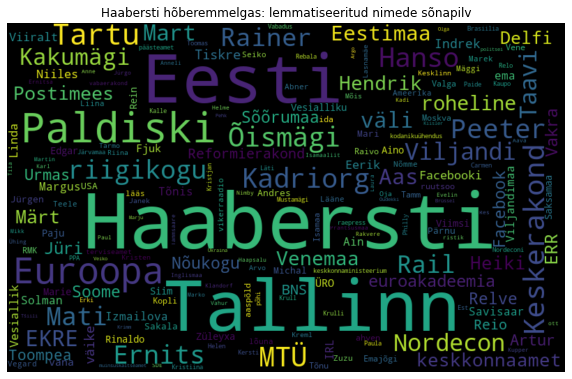

In [40]:
nimed_lemmad = []
for n in tqdm(nimed_texts):
    for sona in n:
        tekst = Text(sona).tag_layer().morph_analysis['lemma']
        nimed_lemmad.append(tekst[0][0])
        #print(tekst[0][0])

nimed_lemmad_words = ' '.join(map(str, nimed_lemmad))

wordcloud_nimed_lemmad = WordCloud(stopwords = stopsõnad_uus, width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(nimed_lemmad_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud_nimed_lemmad, interpolation='bilinear')
plt.title(konflikt + ": lemmatiseeritud nimede sõnapilv")
plt.savefig("tulemused_" + konflikt +"/" + konflikt + " joonis8_Nimed_lemmatiseeritud_sonapilv.png")
plt.axis("off")
print("Nimed sõnapilves: ", len(nimed_lemmad))

In [41]:
jaotus8 =pd.DataFrame(nimed_lemmad, columns=['nimi'])
tabel8 = jaotus8.groupby(['nimi']).size().reset_index(name='esinemissagedus').sort_values(by='esinemissagedus', ascending=False)[:20]
tabel8['osakaal %']= (tabel8['esinemissagedus']/len(nimed_lemmad)*100)
tabel8_1 = tabel8.style.set_caption(konflikt + ": lemmatiseeritud nimede TOP 20")
tabel8.to_excel("tulemused_" + konflikt +"/" + konflikt + " tabel8_Nimed_lemmatiseeritud_TOP_20.xlsx")

In [42]:
tabel8_1

,nimi,esinemissagedus,osakaal %
203,Haabersti,654,11.945205
741,Tallinn,551,10.063927
139,Eesti,492,8.986301
564,Paldiski,111,2.027397
173,Euroopa,86,1.570776
747,Tartu,52,0.949772
434,MTÜ,46,0.840183
305,Kadriorg,45,0.821918
210,Hanso,45,0.821918
999,Õismägi,44,0.803653
